In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.ticker as ticker

In [2]:
# Data explanation

# FONTOS: Minden event-re tamadaskent hivatkozunk (ettol fuggetlenul persze a nagy reszuk nem volt tamdas, csak magas forgalom)

# Tomoren: A components tabla elemei az egyes tamadasok soran keszult 'snapshot'-ok a halozat allapotarol (egy tamadashoz akar tobb ilyen 'snapshot' is lehet)
# Az events tabla elemei pedig egy-egy tamadast irnak le, igazabol az events tabla sorai az azonos Attack ID-val rendelkezo komponensek aggregacioja (atlaga, osszege, stb.)

##### Components #####
# Egy adott idopillanatban tukrozi halozat allapotat, egy snaphot
# Az Attack ID azonositja, hogy melyik tamadasnak a resze az adot idopillanatbeli allapot, ebben a tablaban az Attack ID nem egyedi
Components = {
    "Attack ID": "Egy adott tamadashoz (ami egy event) tartozo azonosito. Egy sora a tablanak azt mondja meg, hogy az adott tamadasnak az adott idopillanatban milyen allapotaban van a halozat.",
    "Detect count": "Azt mondja meg, hogy a bejegyzes az adott Attack ID-ju tamadasnak hanyadik detektalasa. pl lehet, hogy egy tamadast csak egyszer detektalunk, de lehet, hogy a tamadas soran tobbszor is valami gyanusat erzekelt a detektor es ezeket mindet feljegyezte",
    "Card": "A detektor melyik kartyaja vegezte az adatgyujtest",
    "Victim IP": "A tamadas aldozatanak IP cime (anonimizalva)",
    "Port number": "A tamadas cel portja",
    "Attack code": "A tamadas jelleget irja le, amibol gyanus volt a detektornak, hogy tamadas tortenik. pl.: High volume / Suspicious traffic, CLDAP. Akar tobb is lehet egy sorban.",
    "Significant flag": "A DDoS detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Packet speed": "csomagráta (hálózaton áthaladó csomagok száma másodpercenként) [pps]",
    "Data speed": "adatrata (hálózaton áthaladó adatmennyiség másodpercenként) [bps]",
    "Avg packet len": "átlagos csomaghossz [byte]",
    "Source IP count": "Egyedi IP cimek szama, akik az adott idopillanatban tamadnak",
    "Time": "Timestamp, hogy mikor keszult a snapshot"
}


##### Events #####
# egy-egy tamadast reprezental
# Azonos Attack ID-val rendelkezo komponensek aggregacioja, a teljes tamadast reprezentalja, az Attack ID egyedi
Events = {
    "Attack ID": "ugyanaz, mint a Components tablaban, de itt egyedi",
    "Card": "ugyanaz, mint a Components tablaban",
    "Victim IP": "ugyanaz, mint a Components tablaban",
    "Port number": "ugyanaz, mint a Components tablaban",
    "Attack code": "uyanaz, mint a Components tablaban, az adott Attack ID-hoz tartozo osszes komponens Attack code-janak az osszessege",
    "Detect count": "Hanyszor volt az adott Attack ID-val rendelkezo tamadas detektalva.",
    "Singificant flag": "ugyanugy nem fontos",
    "Packet speed": "Atlagos csomagráta a tamadas soran",
    "Data speed": "Atlagos adatrata a tamadas soran",
    "Avg packet len": "Atlagos csomaghossz a tamadas soran",
    "Avg Source IP count": "Atlagososan hany IP-rol tortent a tamadas",
    "Start time": "Timestamp, mikor kezdodott a tamadas",
    "End time": "Timestamp, mikor vegezodott a tamadas",
    "Whitelist flag": "Detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Type": "Az esemeny kategoriaja, aminek a detektor felcimkezte, ezt kell majd nekunk prediktalni neuralis haloval. Itt ez a 'ground truth' adat. Lehetseges ertekei: DDoS attack, Suspicious traffic vagy Normal traffic"
}

In [255]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

class DataPartition(Dataset):
    def __init__(self, data_partition):
        super().__init__()
        self.component_columns = component_columns
        self.event_columns = event_columns
        self.data_partition = data_partition
        self.components, self.events = self.load_data(data_partition)
        self.filter_invalid_rows_from_events()
        self.add_duration_to_events()
        
    def load_data(self, data_partition):
        if data_partition == "A" or data_partition == "B":
            data_path = f'/home/appuser/data/train/SCLDDoS2024_Set{data_partition}'
        elif data_partition == "C":
            data_path = '/home/appuser/data/test/SCLDDoS2024_SetC'
        elif data_partition == "D":
            data_path = '/home/appuser/data/gen/SCLDDoS2024_SetD'
        else:
            raise ValueError("Invalid data partition, the valid options are: A, B, C, D")
        
        components = pd.read_csv(f'{data_path}_components.csv')
        events = pd.read_csv(f'{data_path}_events.csv')
        
        components.columns = self.component_columns
        events.columns = self.event_columns

        return components, events

    # remove the rows that has the End Time set to 0 as we don't know what that means
    def filter_invalid_rows_from_events(self):
        self.events = self.events[self.events['End time'].astype(str) != '0']

    # add a new column to the events dataframe that contains the duration of the event
    def add_duration_to_events(self):
        self.events['Start time'] = pd.to_datetime(self.events['Start time'])
        self.events['End time'] = pd.to_datetime(self.events['End time'])
        self.events['Duration'] = (self.events['End time'] - self.events['Start time']).dt.total_seconds().astype(int)
        
    def get_hist_bins_by_field(self, field):
        if field == "Duration":
            return np.arange(0, 305, 5), 10000
        elif field == 'Detect count':
            return np.arange(0, 51, 1), 50000
        else:
            raise ValueError("You provided an invalid field option")

    # How much of the datatset is DDos attack, normal traffic and suspicious traffic
    def create_dist_pie_chart_for_events(self, save=False):
        event_types = self.events['Type'].value_counts()
        percentages = event_types / event_types.sum() * 100  # Calculate percentages
        labels = [f"{label} ({percent:.1f}%)" for label, percent in zip(event_types.index, percentages)]  # Add percentages to labels
        
        event_types.plot.pie(labels=labels, autopct='', startangle=0, fontsize=12)  # Remove autopct
        plt.ylabel('')
        plt.title(f'Event type distribution for data partition {self.data_partition}', fontsize=16)
        if save:
            plt.savefig(f'plots/event_distribution_{self.data_partition}.png',bbox_inches='tight')
        plt.show()
        
    # Create a histogram based on the 'field' column
    def create_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        plt.figure(figsize=(27, 9))
        bins, ymax = self.get_hist_bins_by_field(field)

        ax = sns.histplot(
            data=data, 
            x=field,
            hue='Type',  
            bins=bins, 
            multiple="stack",  
            alpha=0.8,
            hue_order=["DDoS attack", "Suspicious traffic", "Normal traffic"],
            palette={
                "DDoS attack": "#28a745",
                "Suspicious traffic": "#dc3545",
                "Normal traffic": "#007bff"
            },
            legend=True,
            edgecolor='none',
            element='bars',
            shrink=0.9,
        )

        plt.gca().set_facecolor('lavender')
        plt.title(f'Event {field} histogram for data partition {self.data_partition}', fontsize=20)
        plt.xlabel(f'{field}', fontsize=18)
        plt.ylabel('Number of Occurrences', fontsize=18)
        plt.ylim(0, ymax)
        xmax = max(bins)
        plt.xlim(0, xmax)

        # Format y-axis labels to show 'k' for thousands
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

        # Increase font size for axis labels and ticks
        plt.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)
        
        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the columns)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1) 
        
        if save:
            plt.savefig(f'plots/event_{field}_histogram_{self.data_partition}.png', bbox_inches='tight')
        plt.show()
        
    # Create a binwise normalised histogram based on the 'field' column
    def create_normalized_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        bins, _ = self.get_hist_bins_by_field(field)

        # Assign each data point to a bin
        data['bin'] = pd.cut(data[field], bins=bins, include_lowest=True)
    
        # Compute counts per bin per type
        counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)

        # Normalize each bin so columns sum to 1
        normalized_counts = counts.div(counts.sum(axis=1), axis=0).fillna(0)        

        # Define categories
        categories = ["DDoS attack", "Suspicious traffic", "Normal traffic"]
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(normalized_counts)) 
        for cat, color in zip(categories, colors):
            sns.barplot(
                x=bins[1:], 
                y=normalized_counts[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += normalized_counts[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Event {field} normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel(f'{field}', fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_{field}_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()

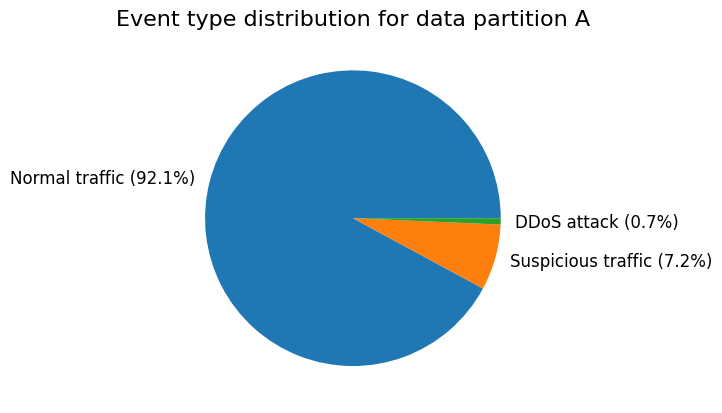

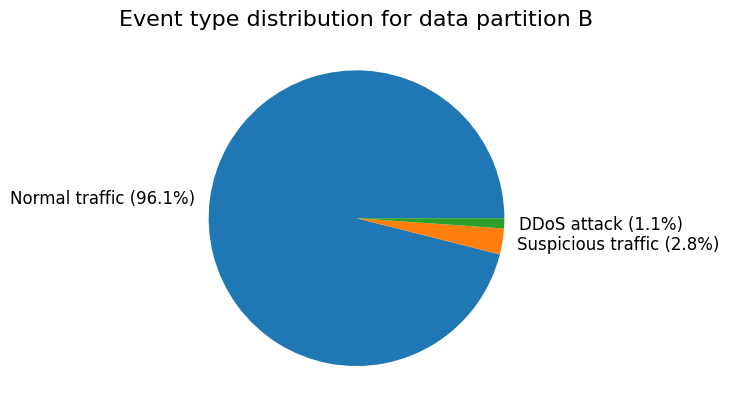

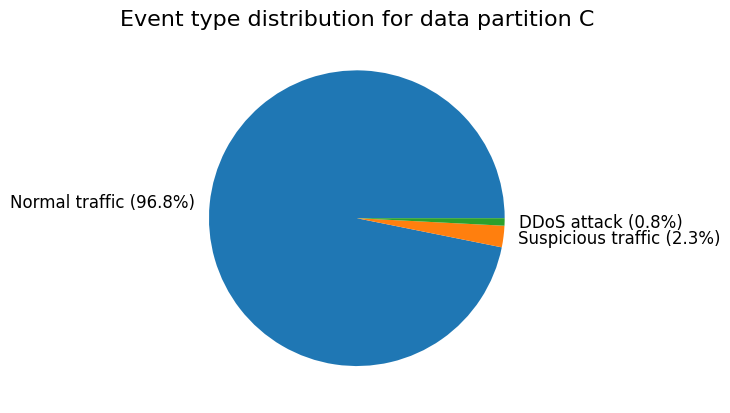

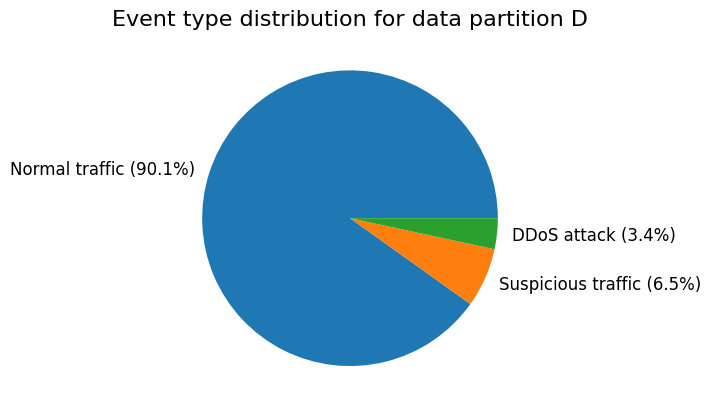

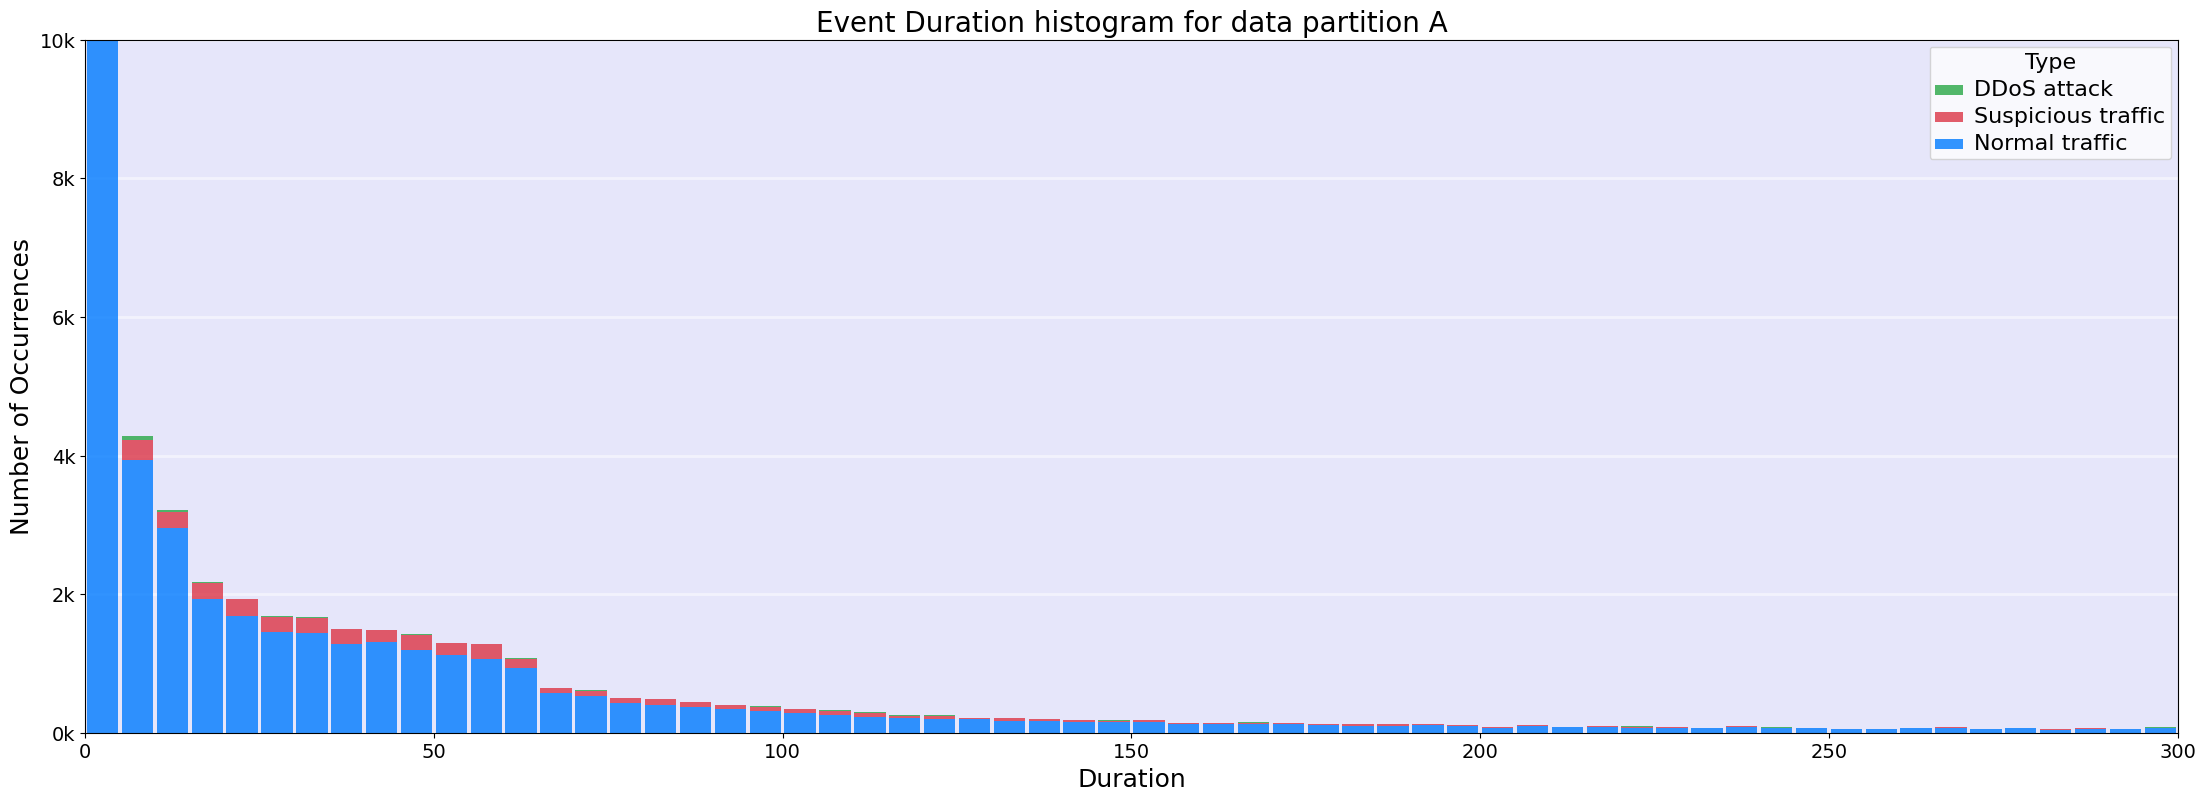

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


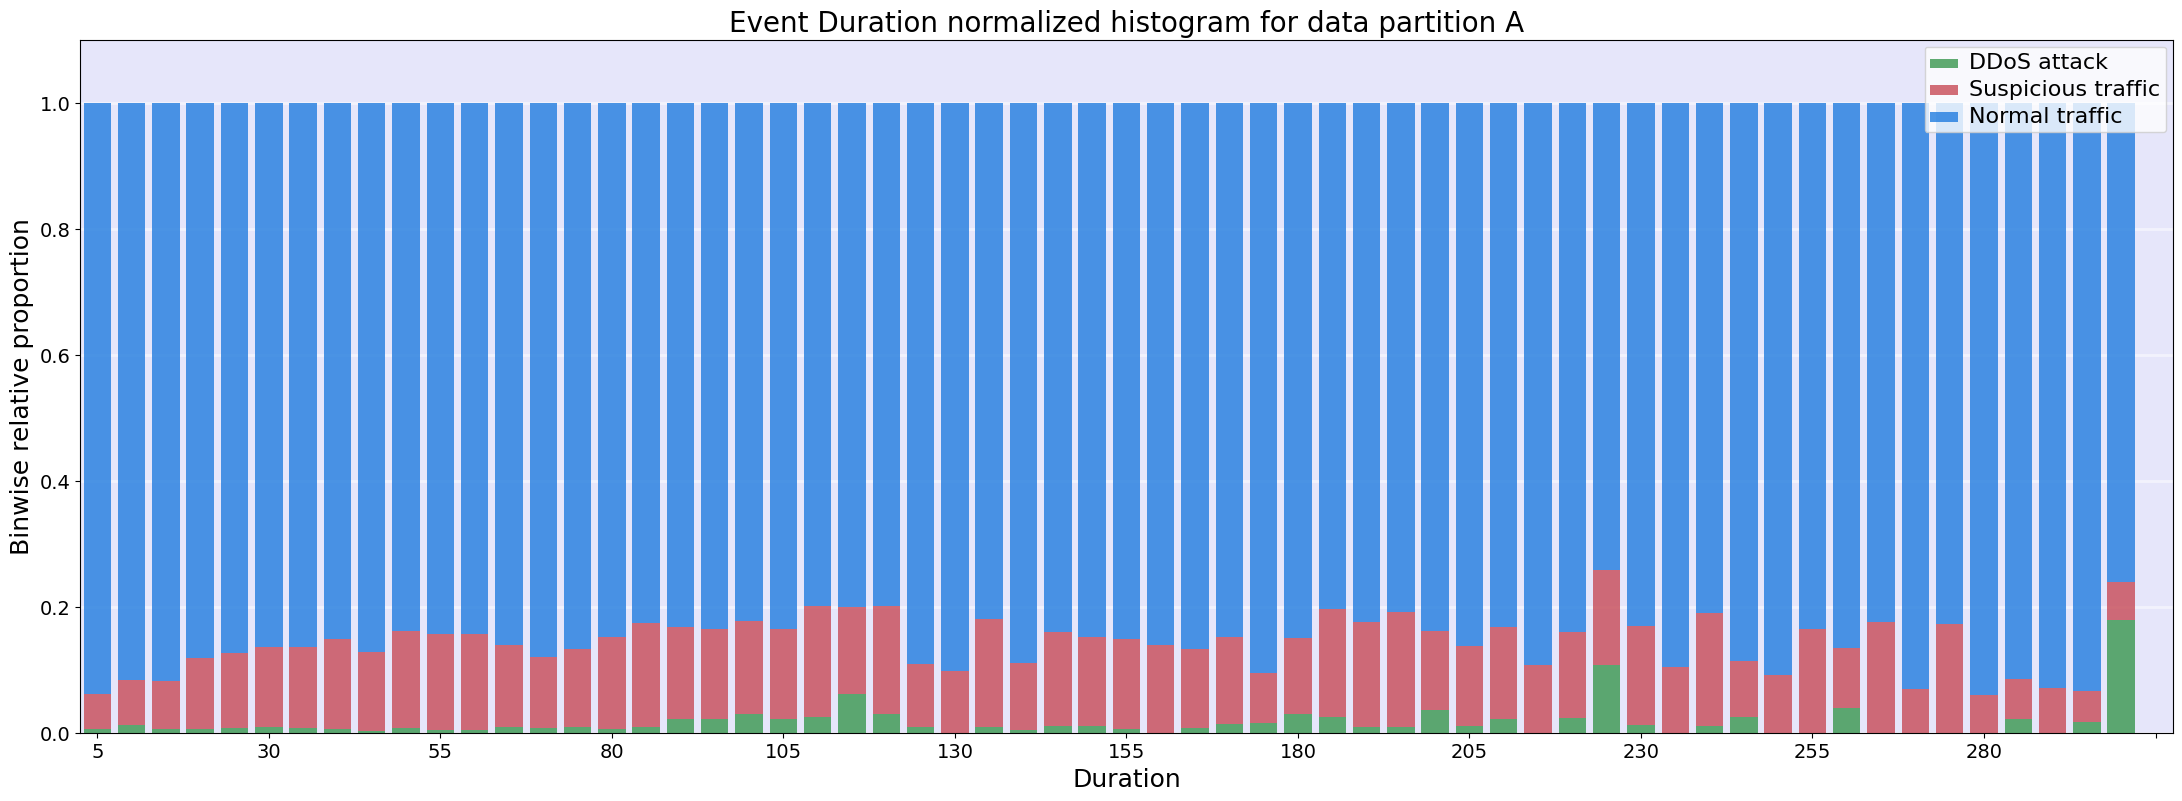

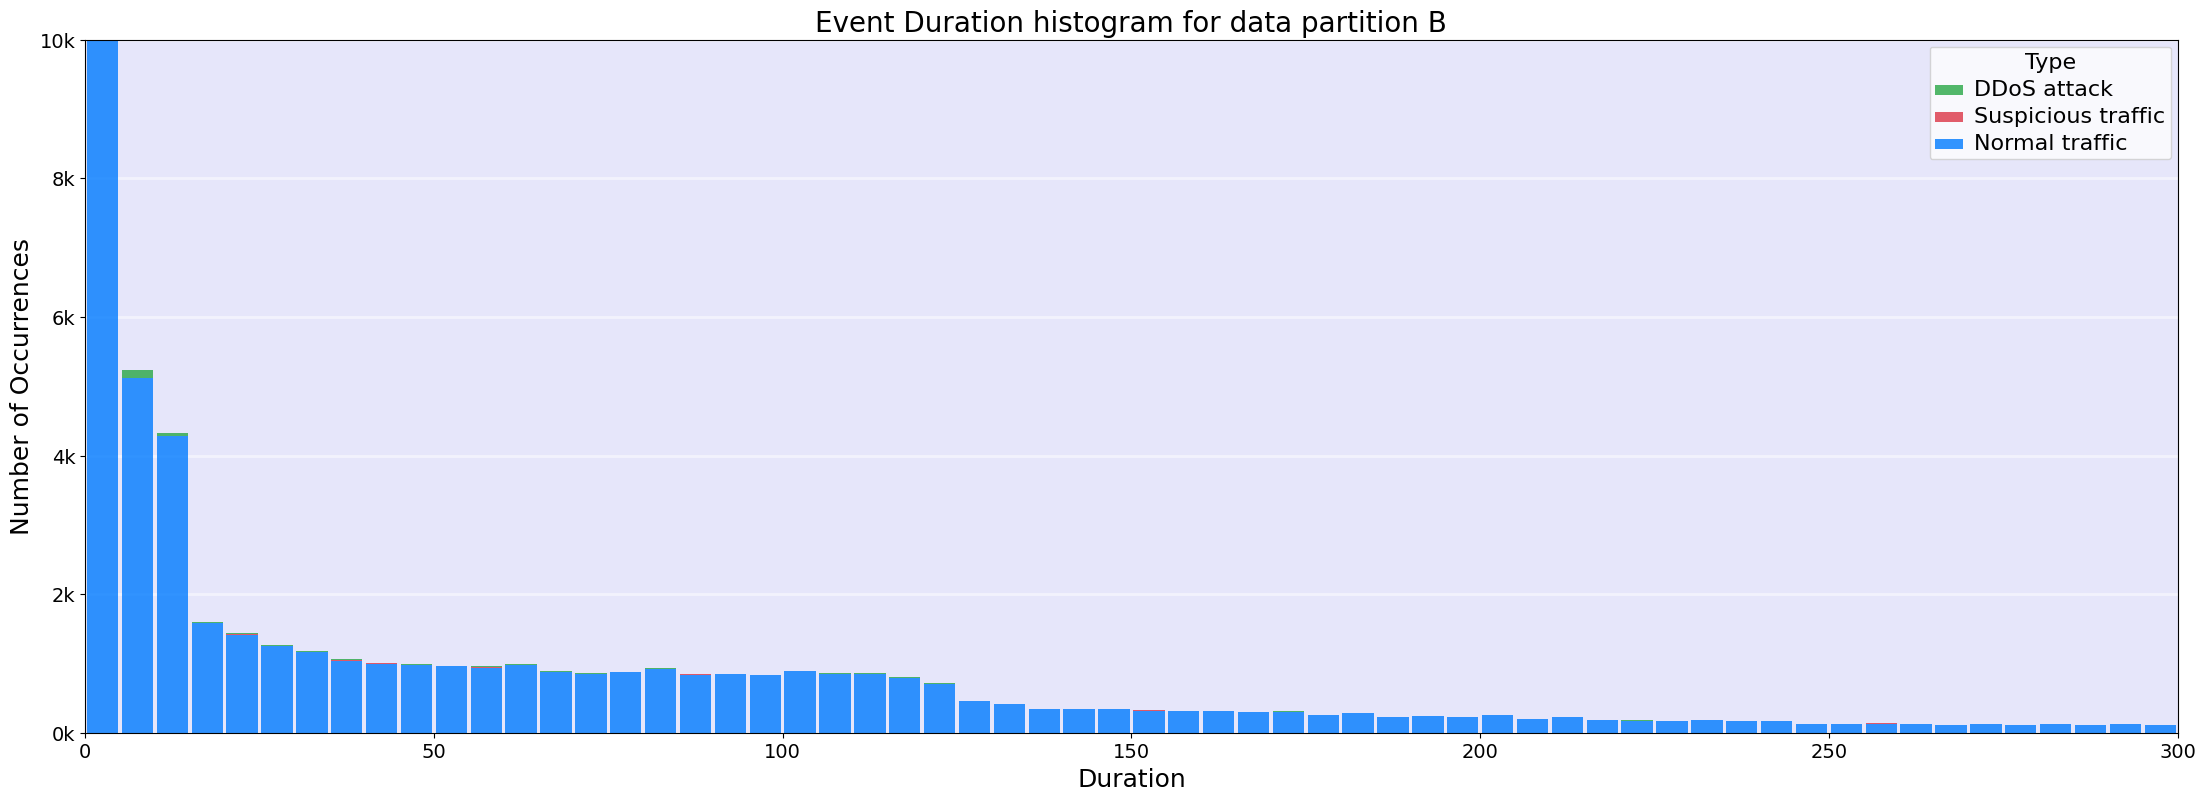

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


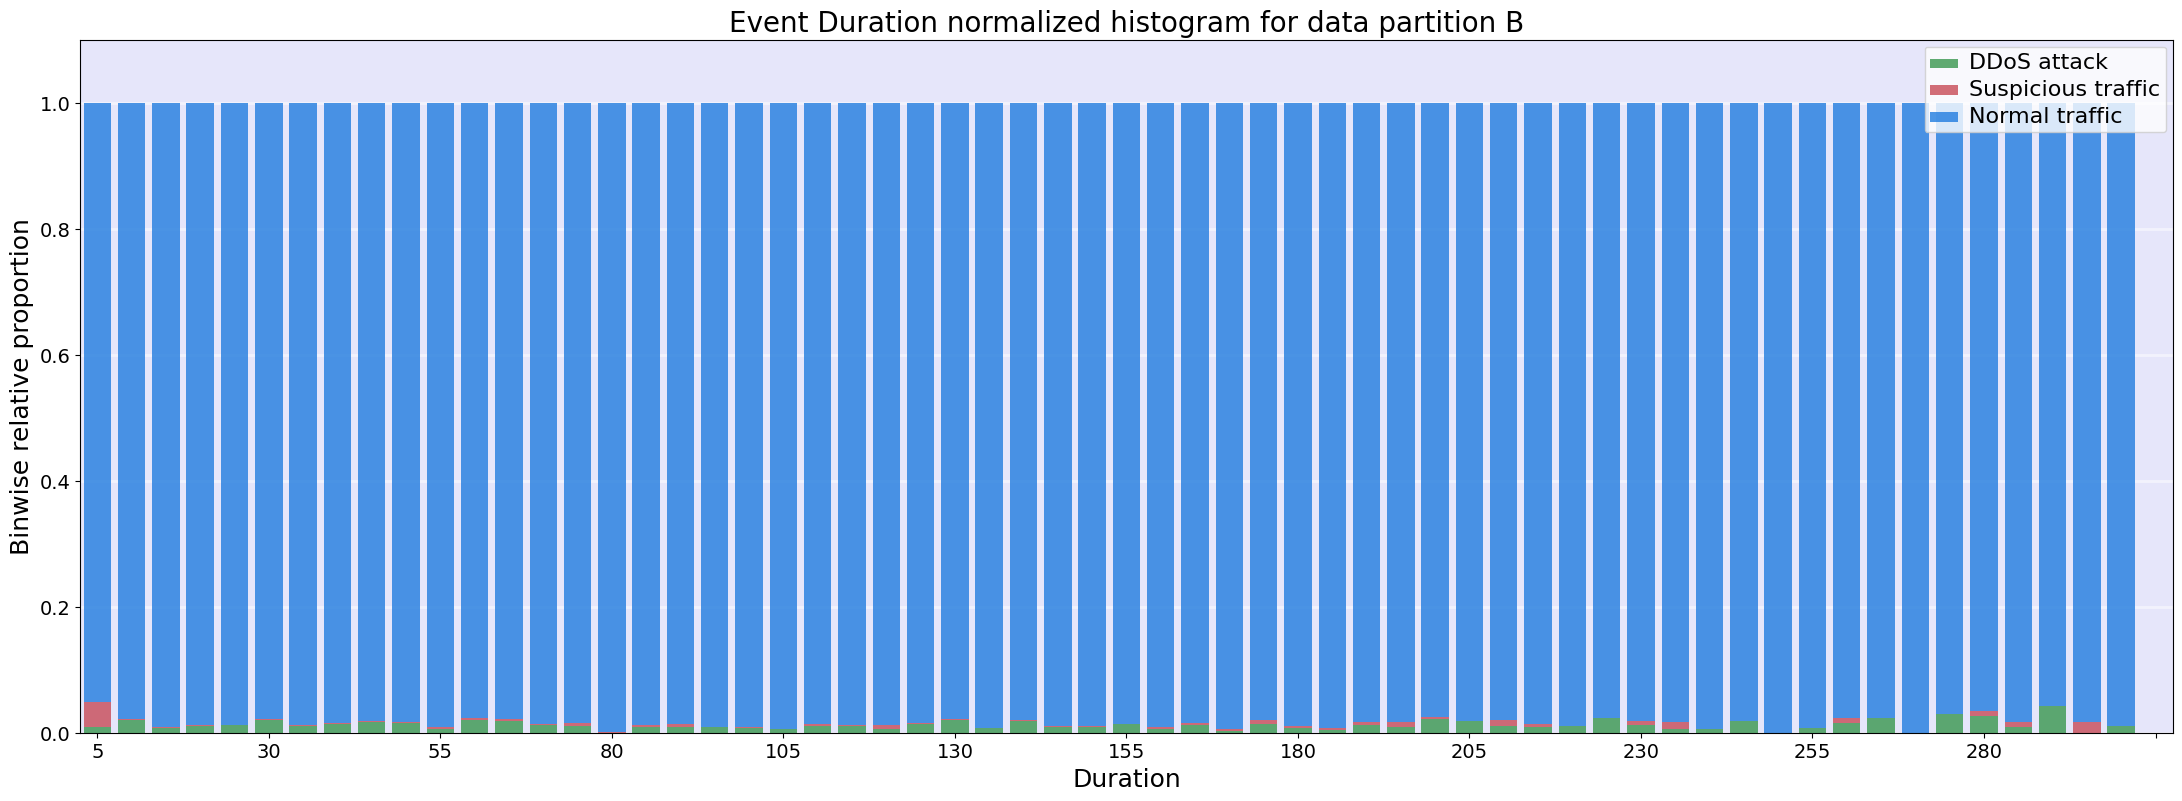

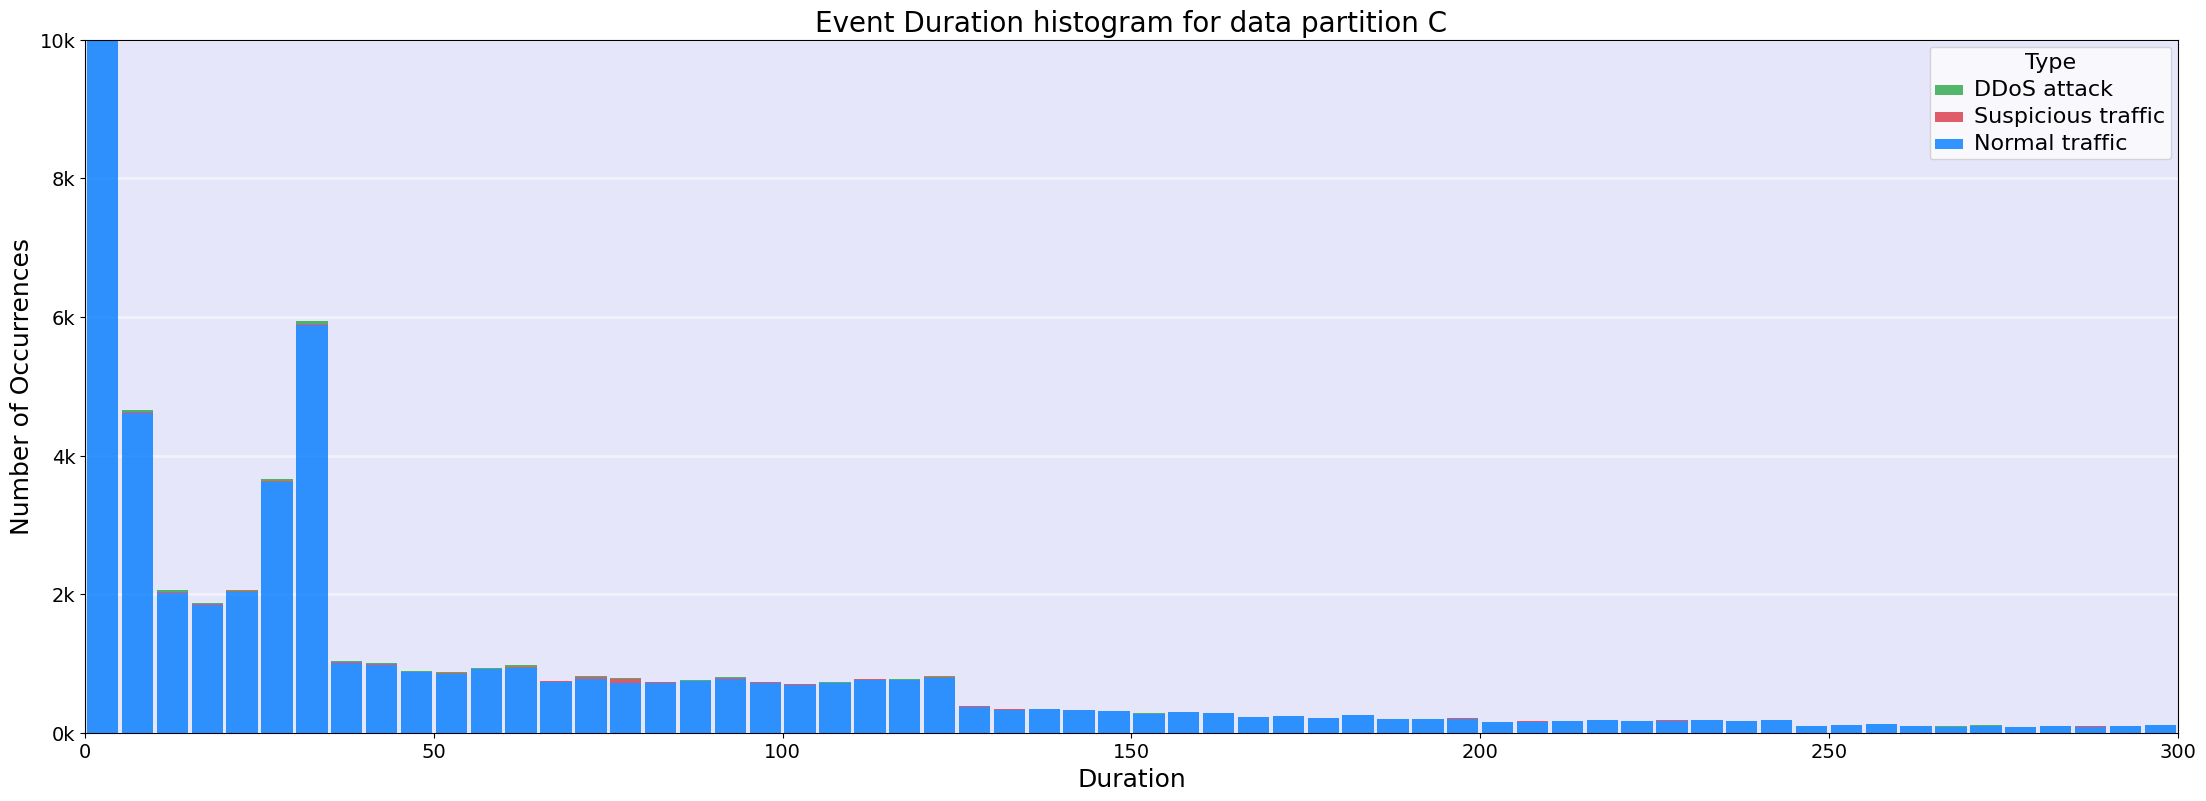

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


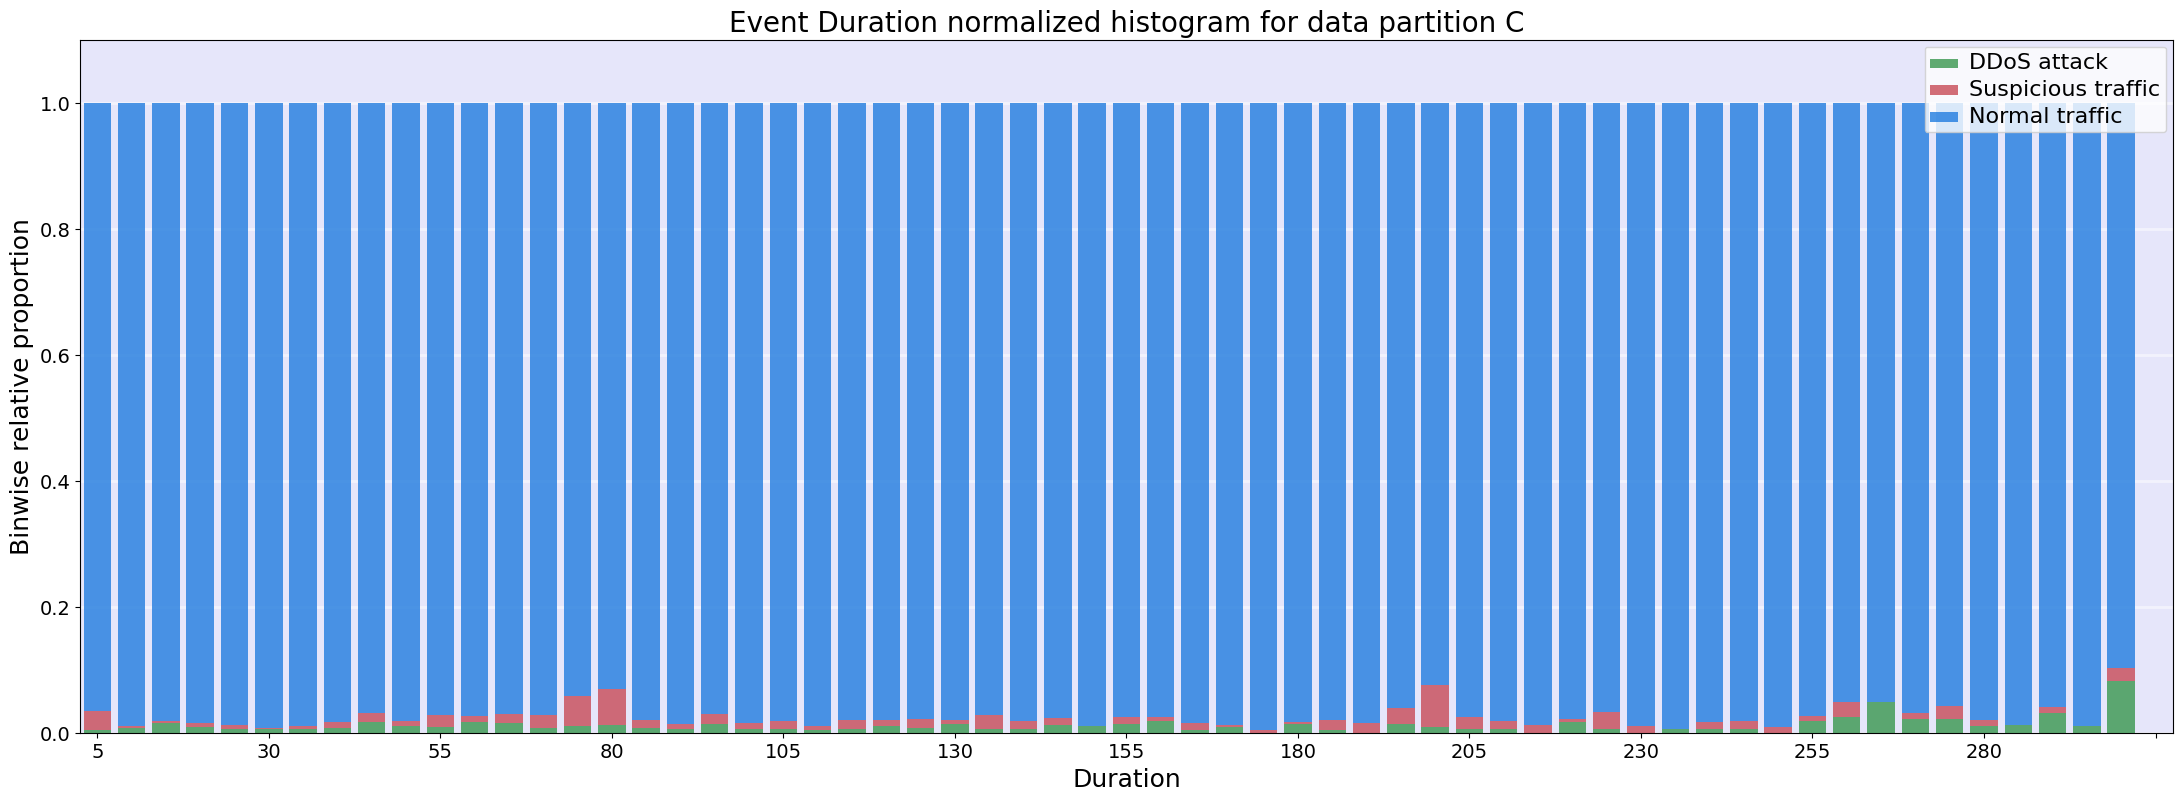

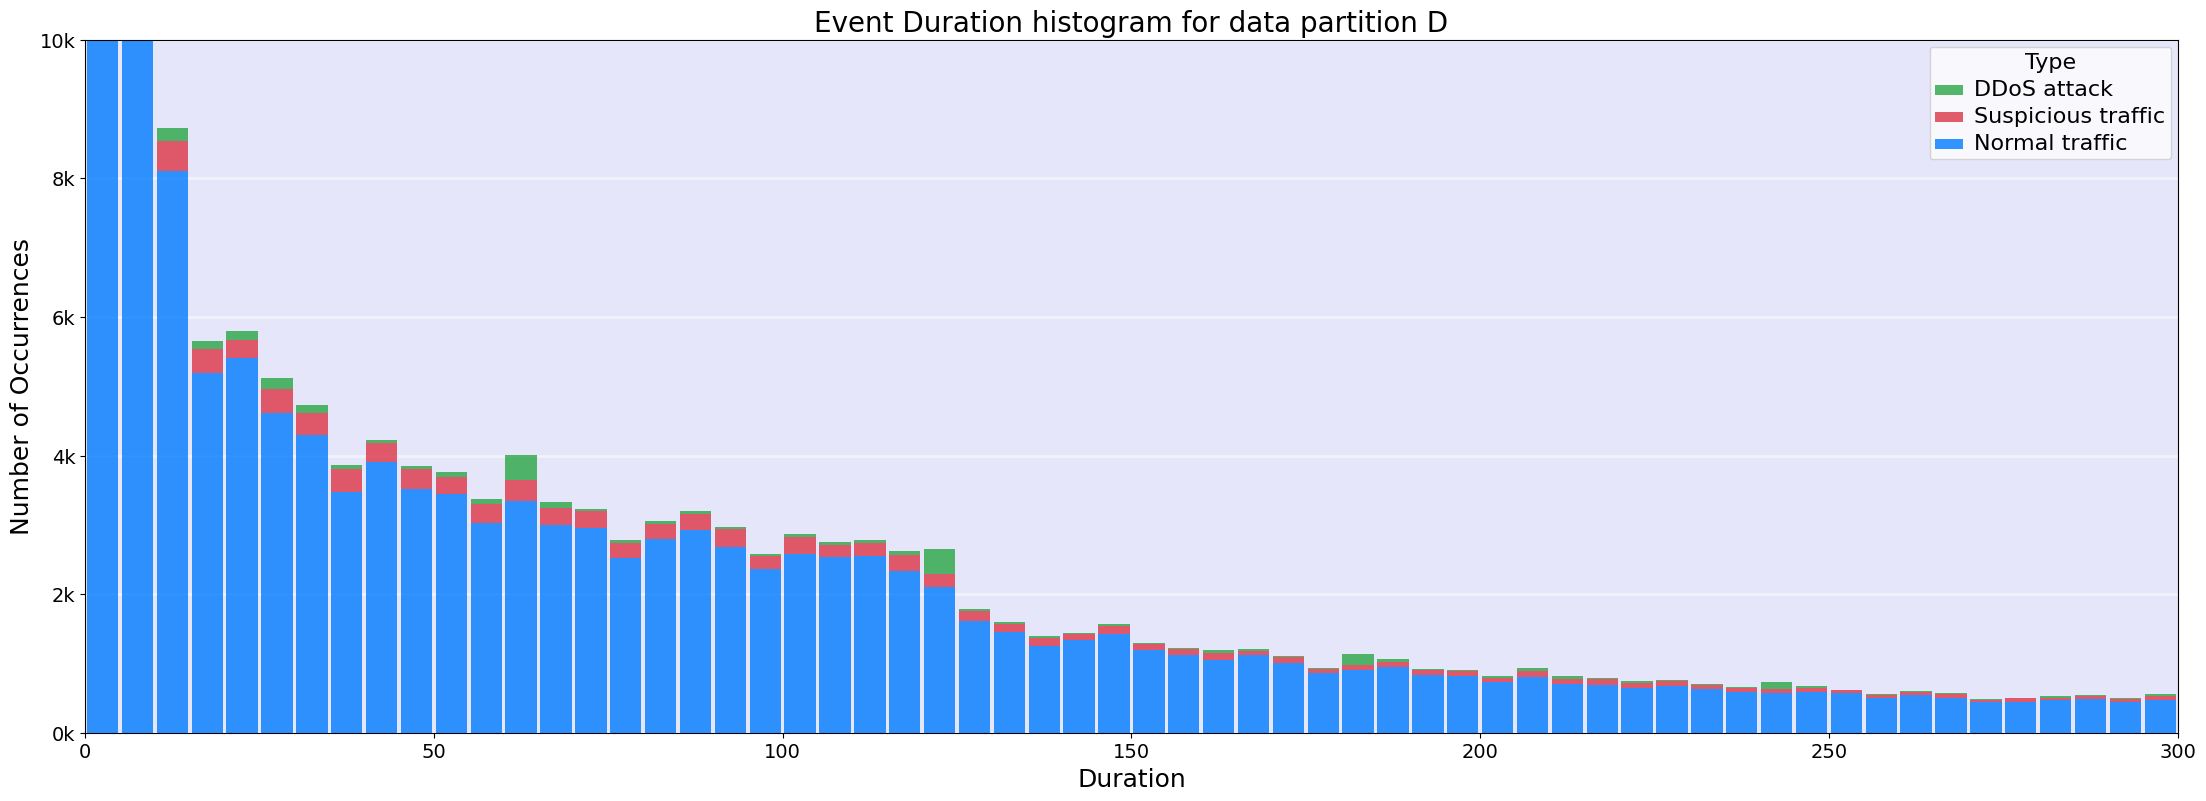

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


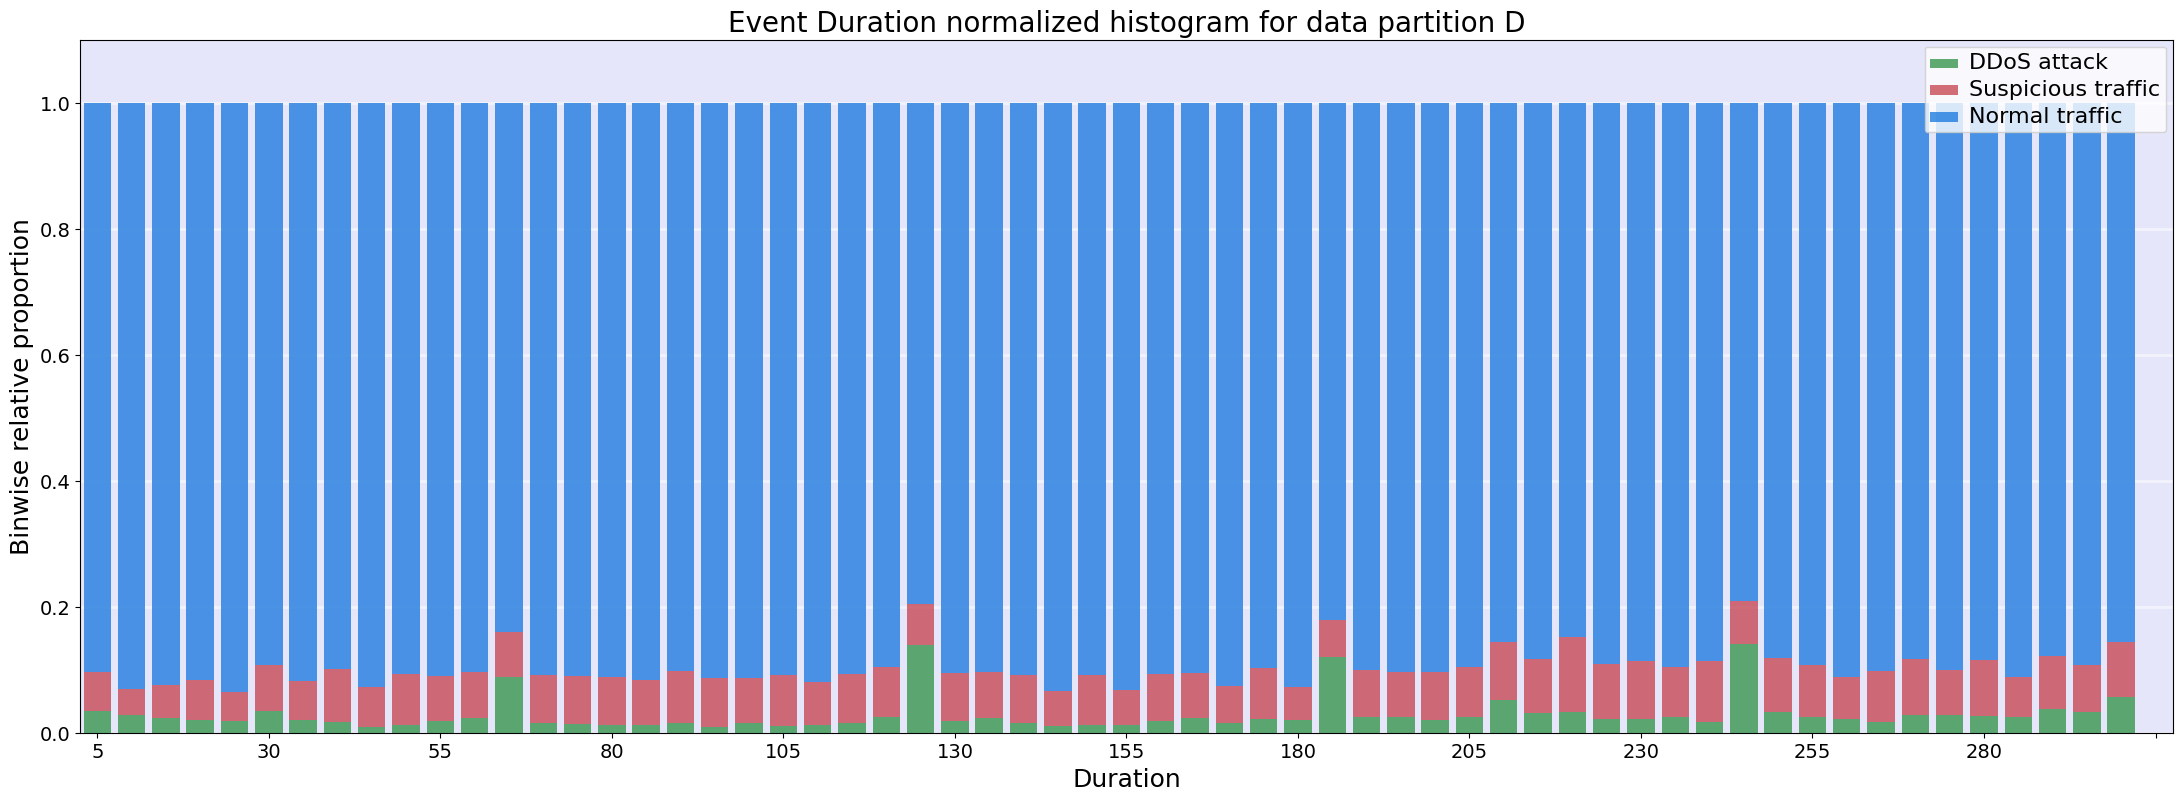

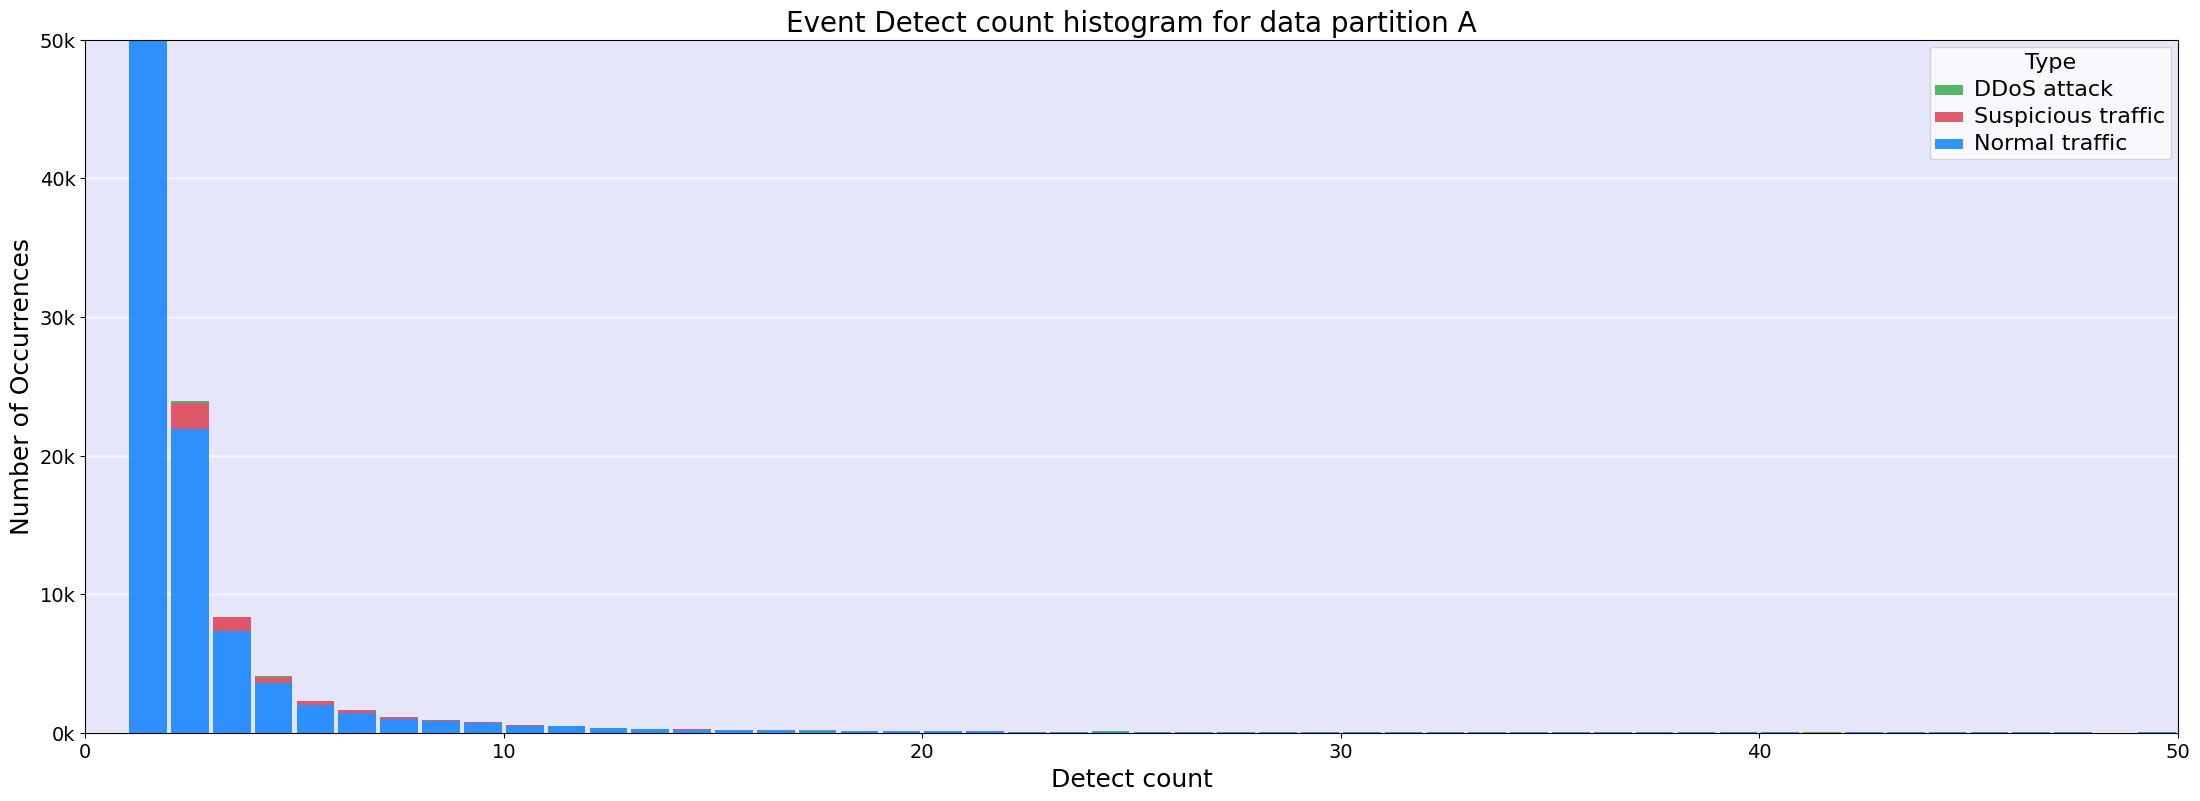

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


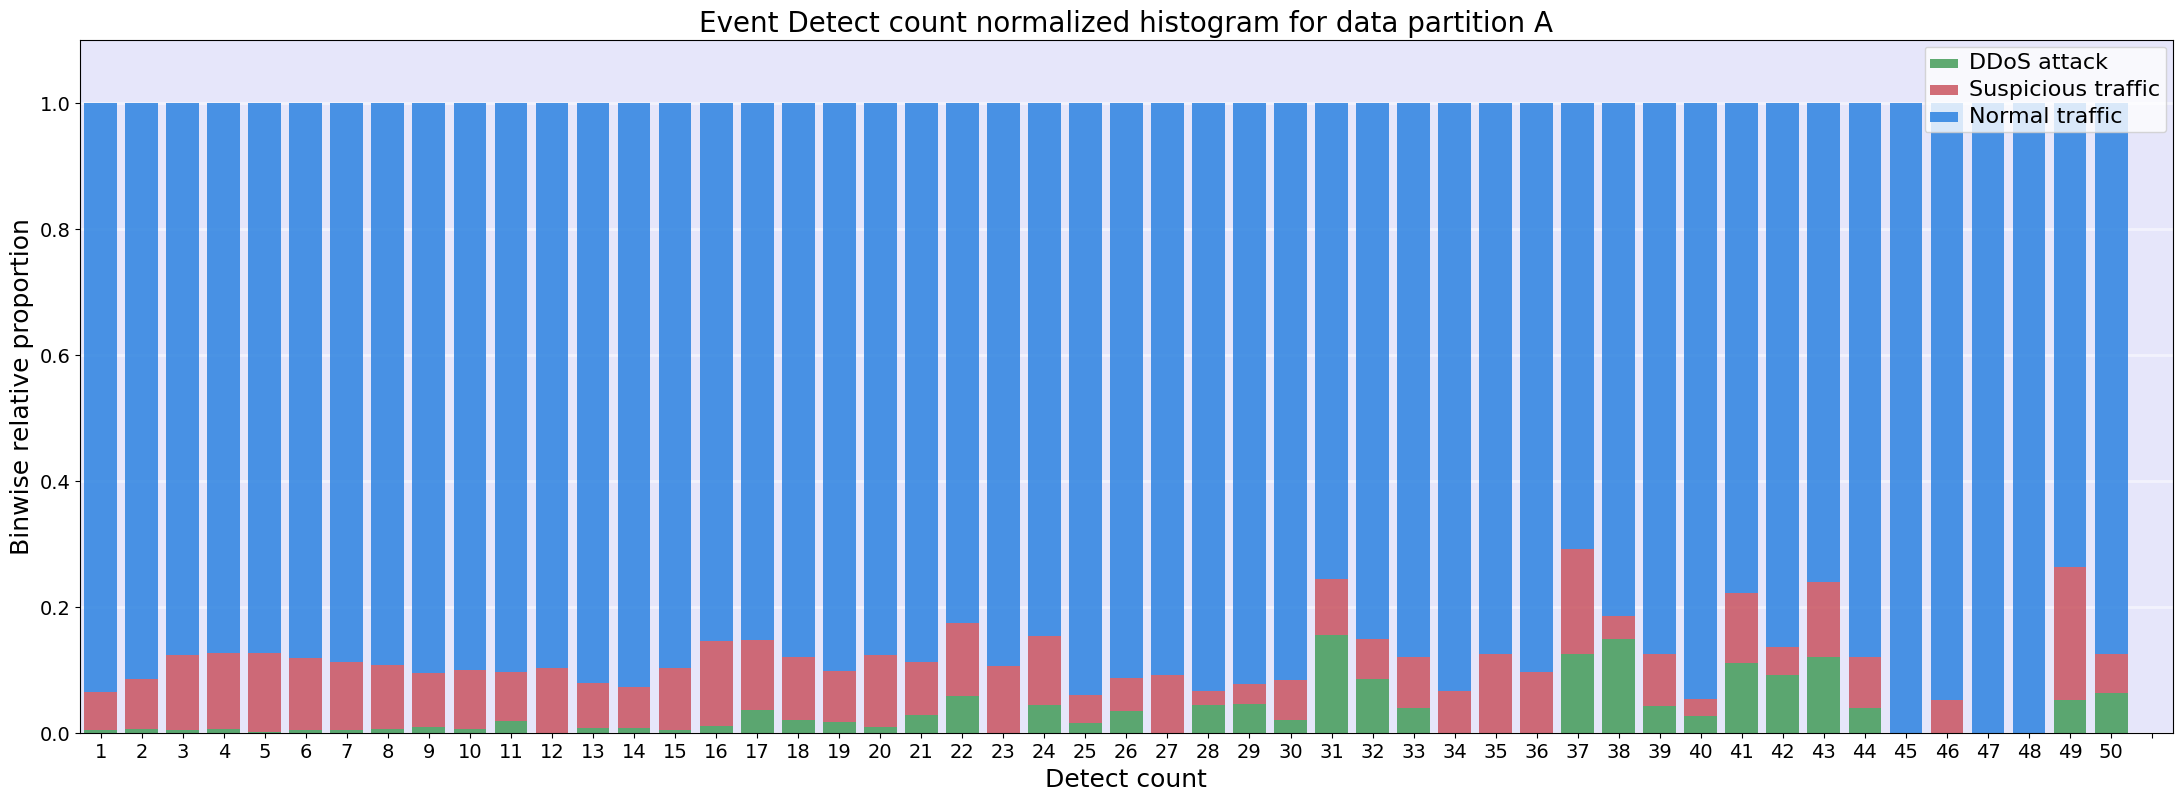

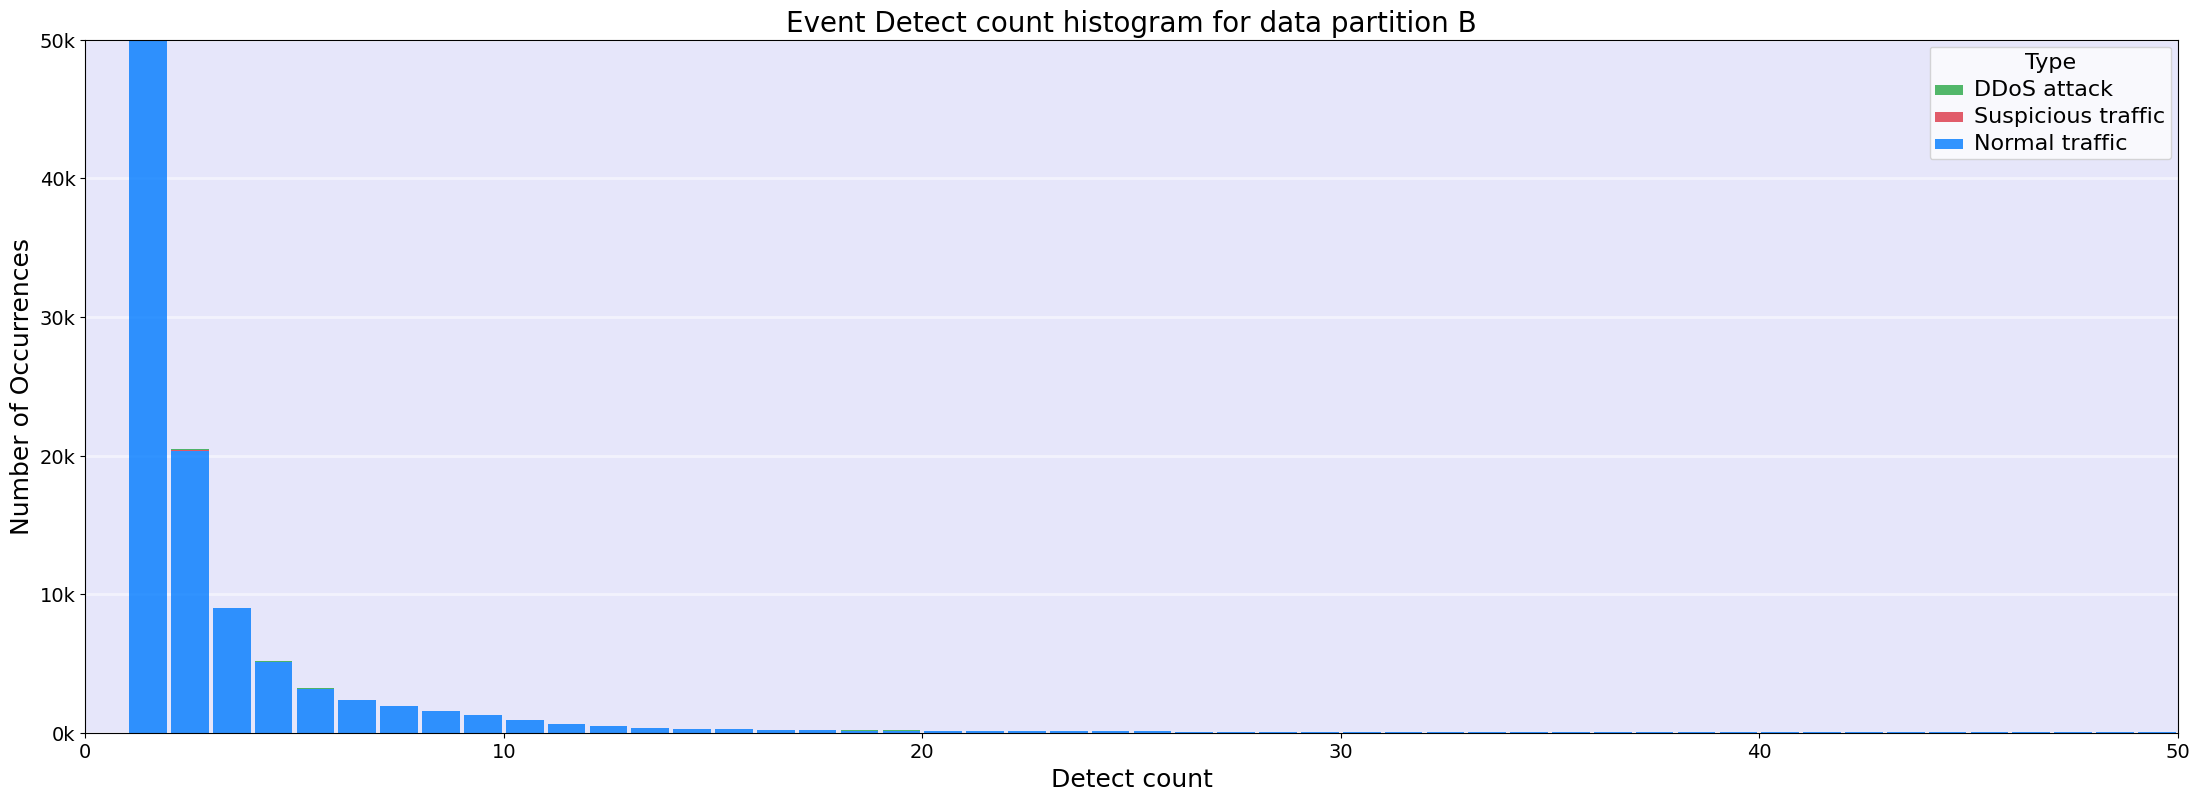

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


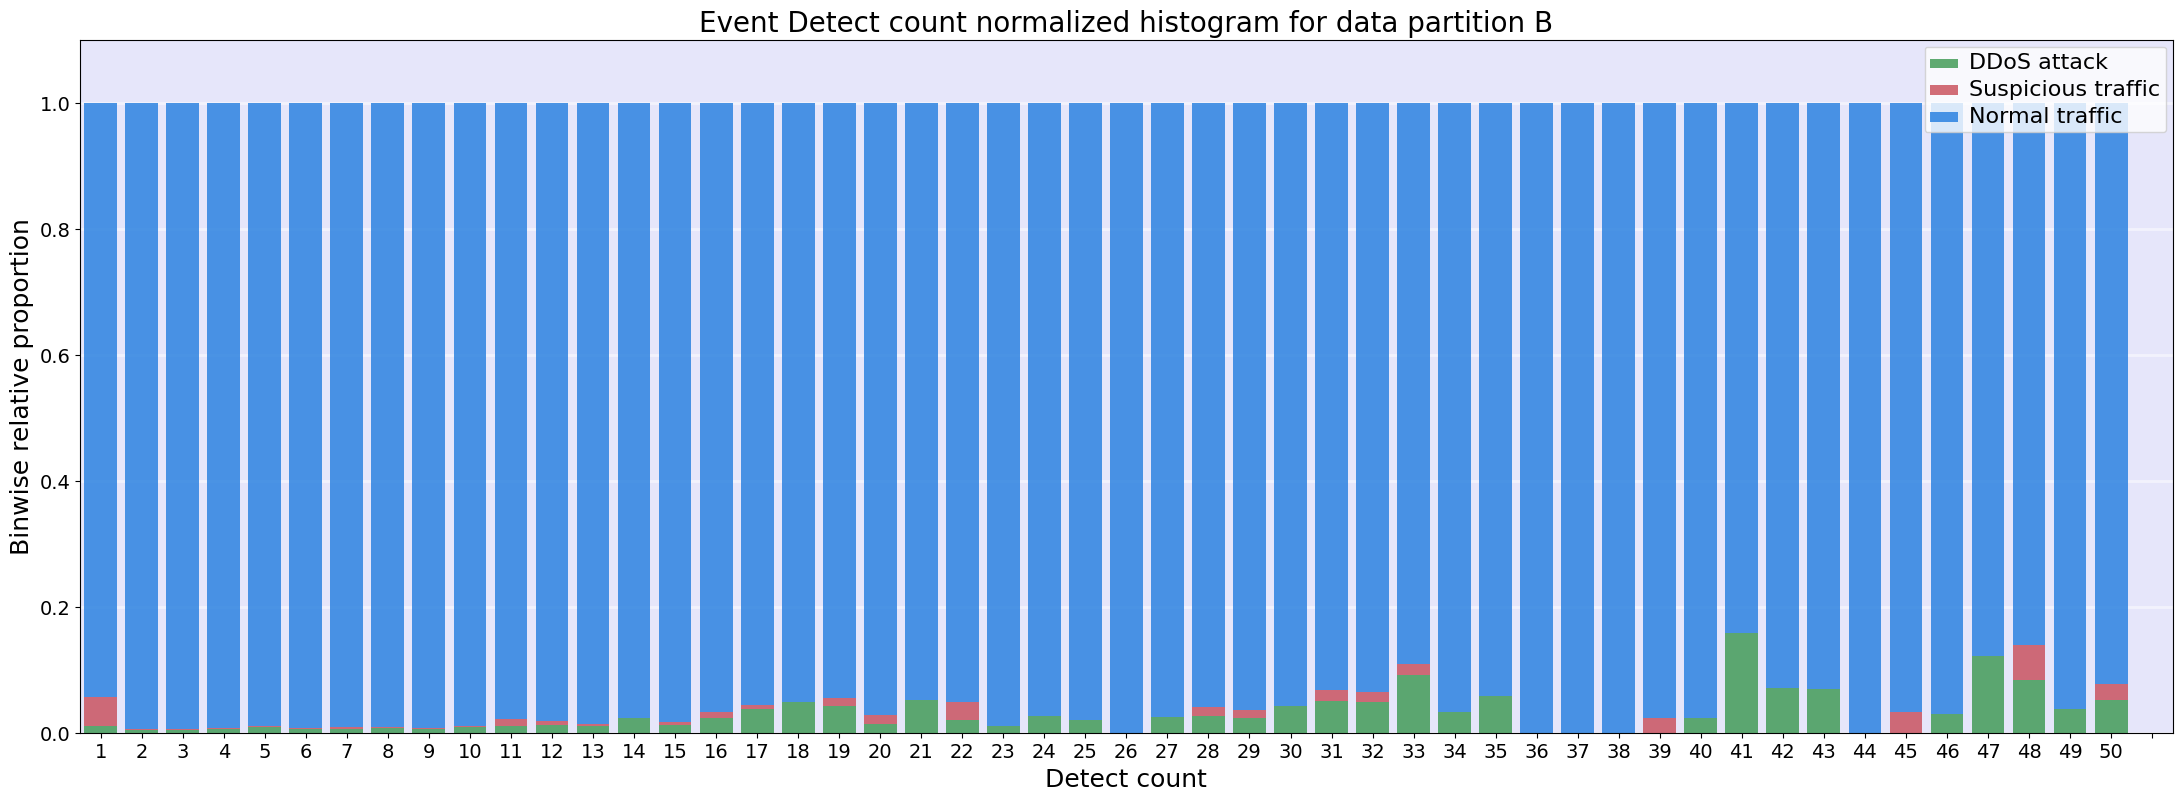

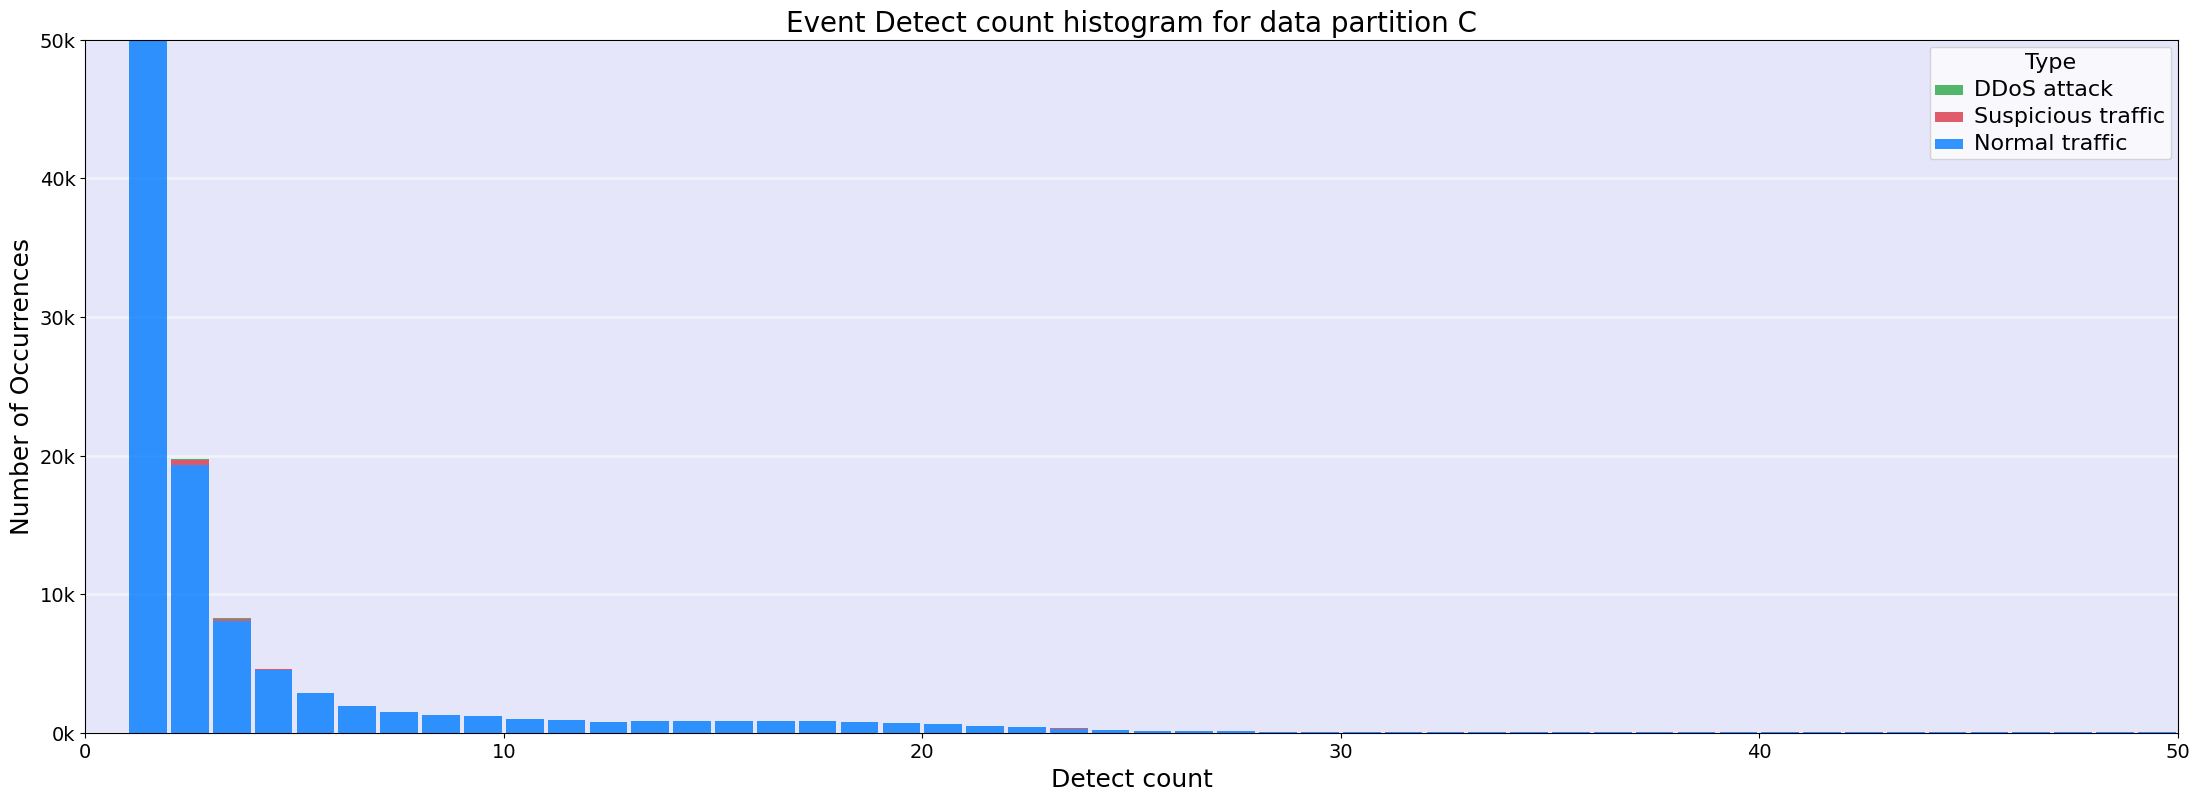

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


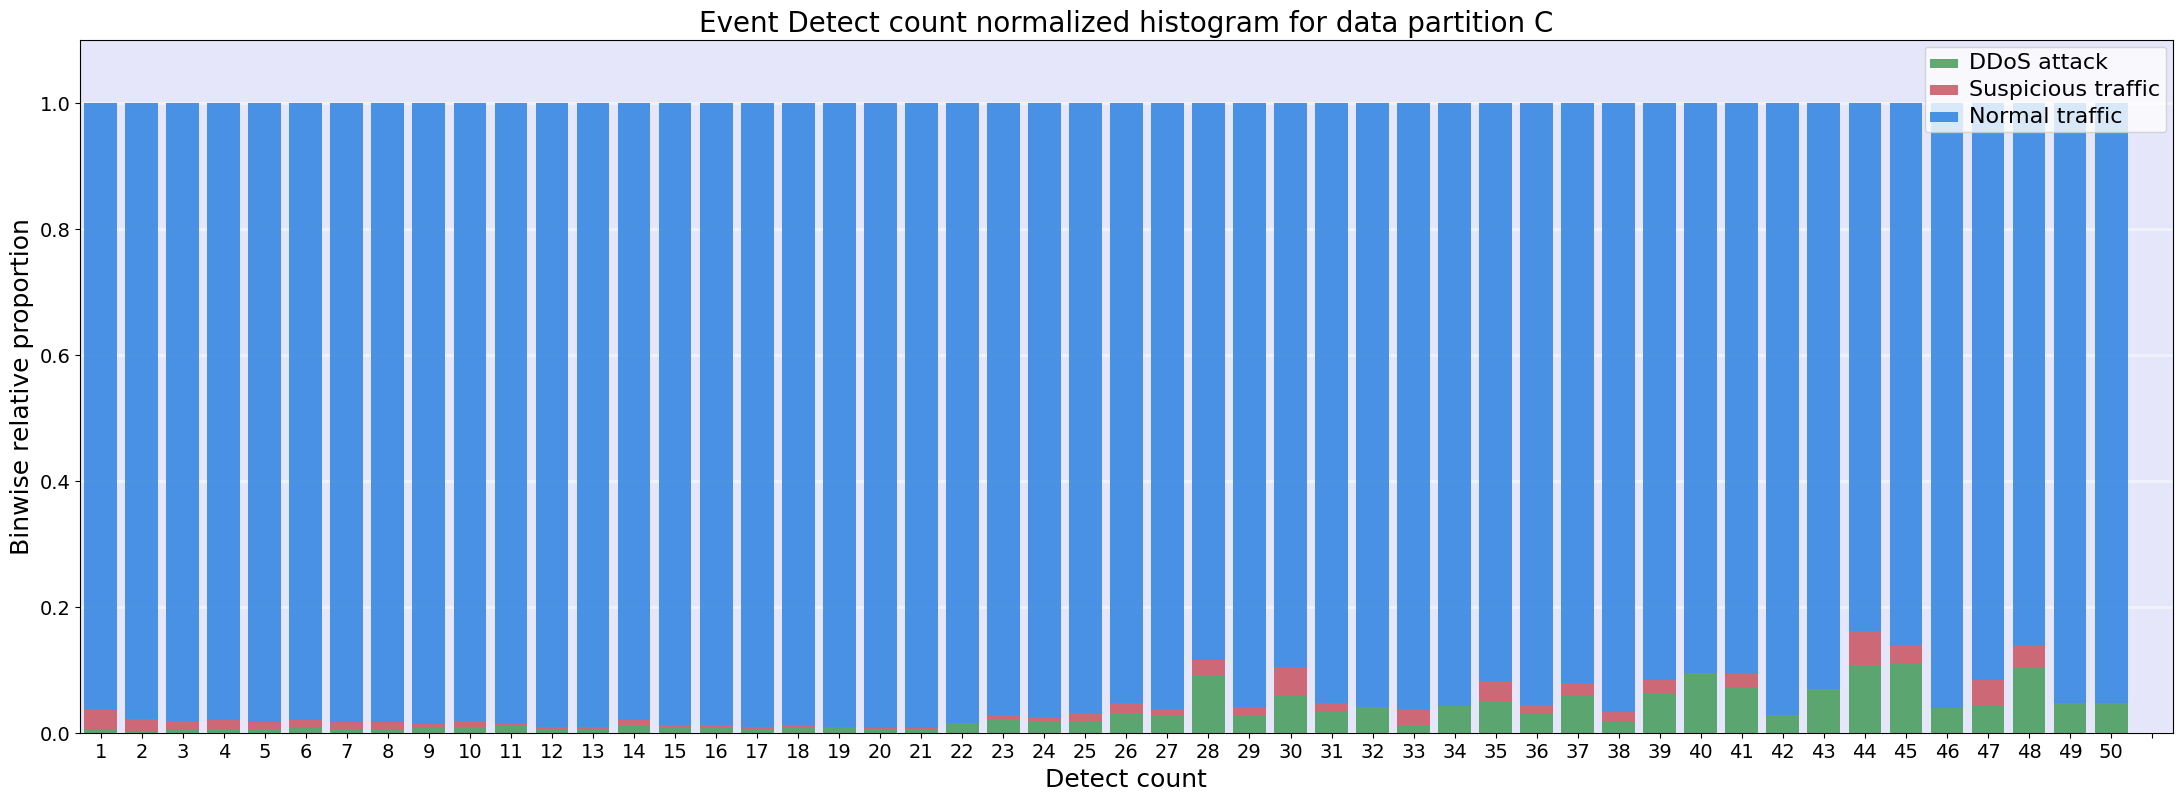

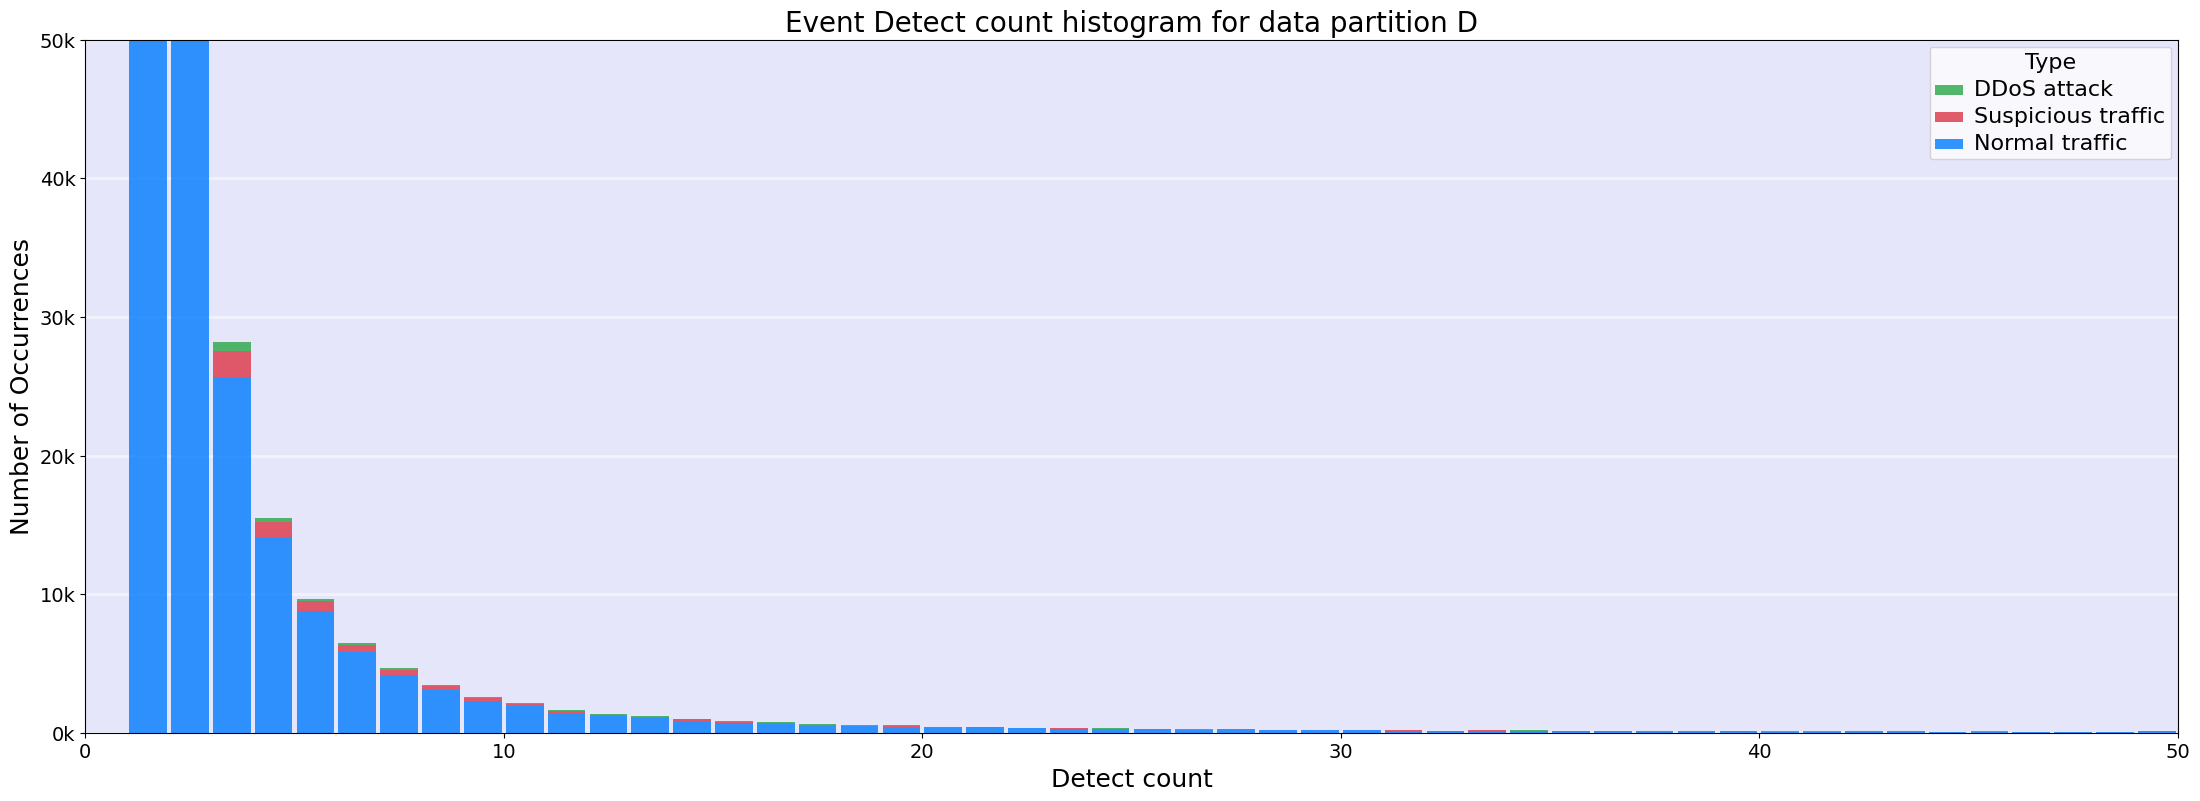

/tmp/ipykernel_12037/3652145676.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


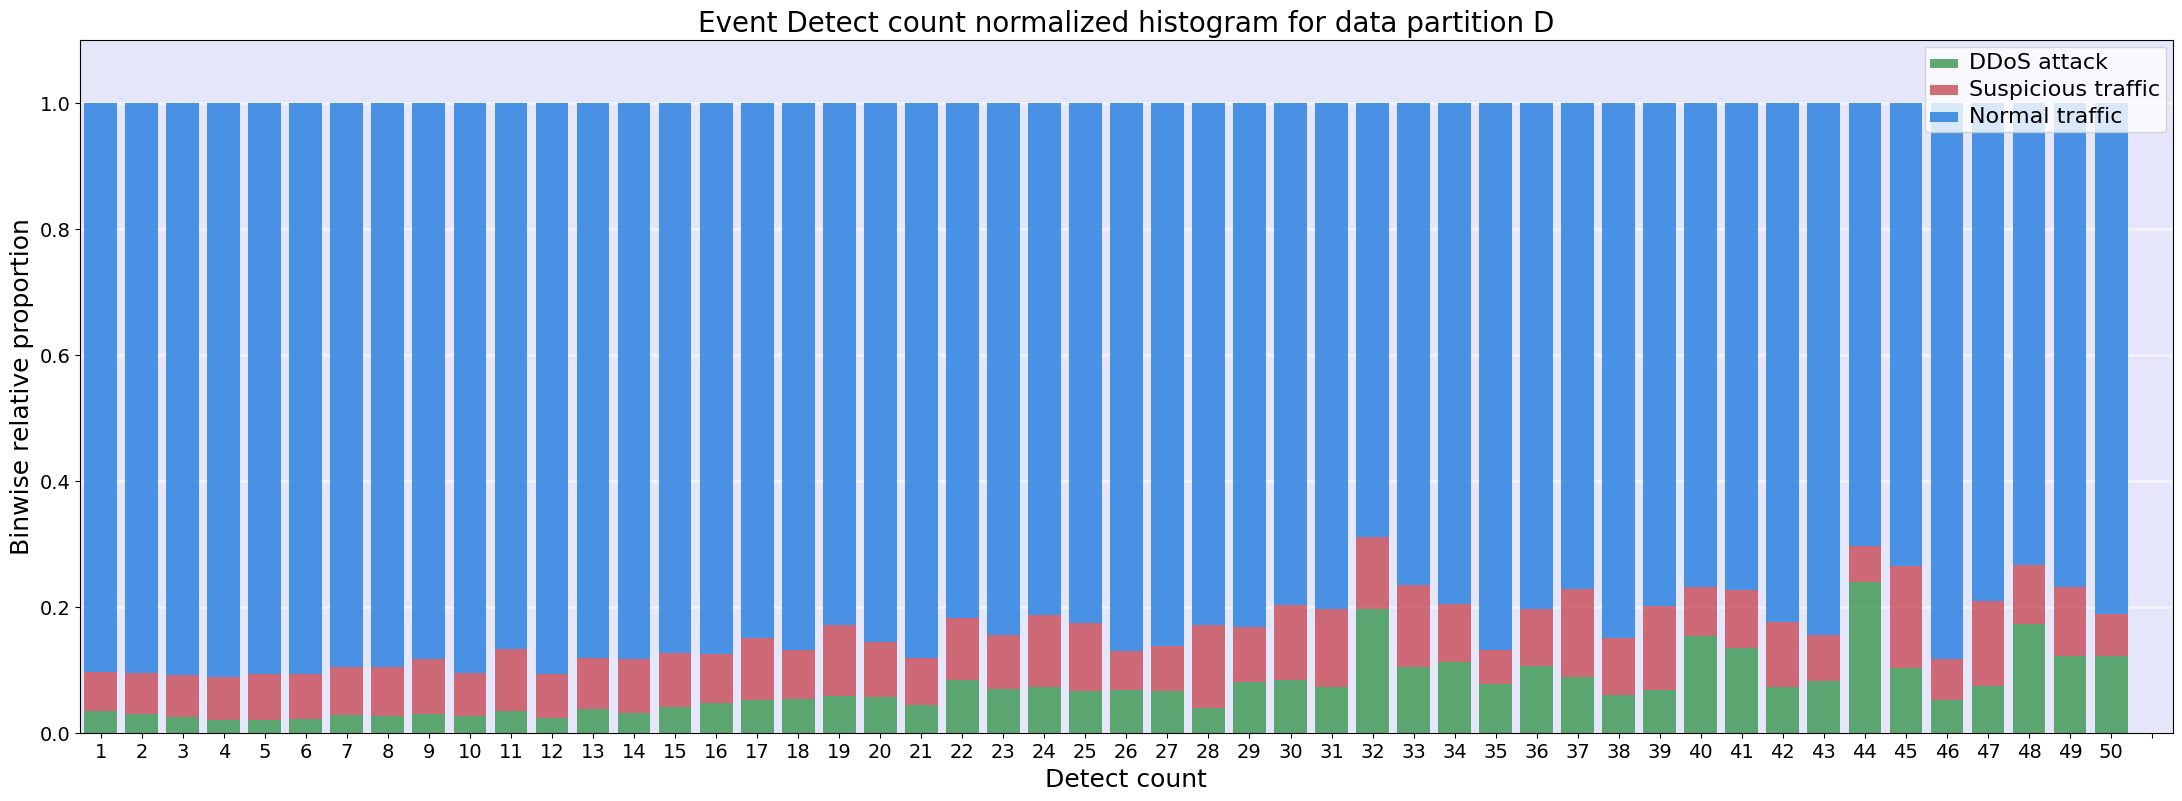

In [256]:
save_plots = True
fields = ['Duration', 'Detect count']

partition_a = DataPartition('A')
partition_b = DataPartition('B')
partition_c = DataPartition('C')
partition_d = DataPartition('D')

partition_a.create_dist_pie_chart_for_events(save=save_plots)
partition_b.create_dist_pie_chart_for_events(save=save_plots)
partition_c.create_dist_pie_chart_for_events(save=save_plots)
partition_d.create_dist_pie_chart_for_events(save=save_plots)

for field in fields:
    partition_a.create_histogram_for_events(field, save=save_plots)
    partition_a.create_normalized_histogram_for_events(field=field, save=save_plots)


    partition_b.create_histogram_for_events(field, save=save_plots)
    partition_b.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_c.create_histogram_for_events(field, save=save_plots)
    partition_c.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_d.create_histogram_for_events(field, save=save_plots)
    partition_d.create_normalized_histogram_for_events(field=field, save=save_plots)